In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import visionloader as vl
from sklearn.cluster import SpectralClustering
import os
import src.fitting as fitting
import src.multielec_utils as mutils
import src.old_labview_data_reader as oldlv
from mpl_toolkits.mplot3d import Axes3D
import cvxpy as cp
from scipy.optimize import minimize
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Load in triplet stim elecResps and amplitudes

In [2]:
# Current values in uA

Ivals = np.array([0.10053543, 0.11310236, 0.11938583, 0.13195276, 0.14451969,                        
                       0.16337008, 0.17593701, 0.1947874 , 0.2136378 , 0.23877165,
                       0.25762205, 0.2780315 , 0.30330709, 0.35385827, 0.37913386,
                       0.42968504, 0.45496063, 0.50551181, 0.55606299, 0.60661417,
                       0.68244094, 0.73299213, 0.8088189 , 0.88464567, 0.98574803,
                       1.10433071, 1.20472441, 1.30511811, 1.40551181, 1.60629921,
                       1.70669291, 1.90748031, 2.10826772, 2.30905512, 2.50984252,
                       2.81102362, 3.11220472, 3.41338583, 3.71456693, 4.1161])

In [3]:
ANALYSIS_BASE = "/Volumes/Analysis"
gsort_path = "/Volumes/Scratch/Users/praful/newlv_gsort_v2_30um_periphery"
gsort_path_1elec = "/Volumes/Scratch/Users/praful/single_gsort_v2_30um_periphery-affinity_cosine"

In [4]:
dataset = "2020-10-18-5"
estim = "data006/data006-all_v2"
estim_1elec = "data001"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

In [5]:
wnoise = "kilosort_data002/data002"
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vis_datarun = wnoise.split('/')[-1]
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [6]:
p = 2
targets = np.array([197, 212])
nontargets = np.array([220])

<IPython.core.display.Javascript object>


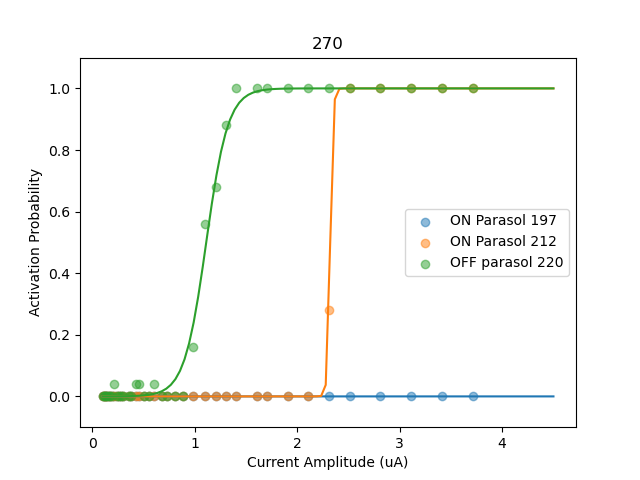

<IPython.core.display.Javascript object>


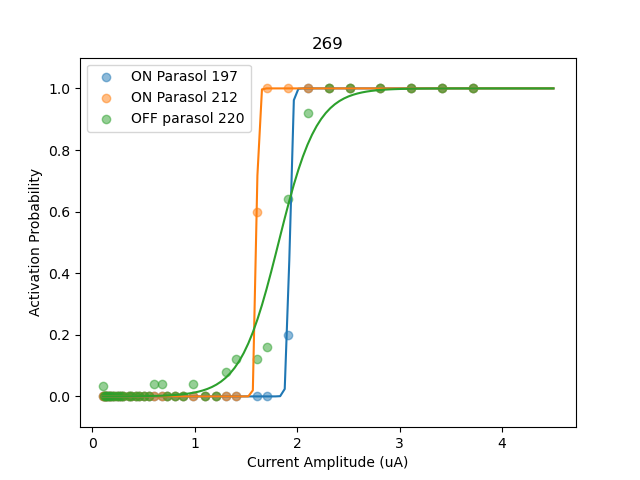

<IPython.core.display.Javascript object>


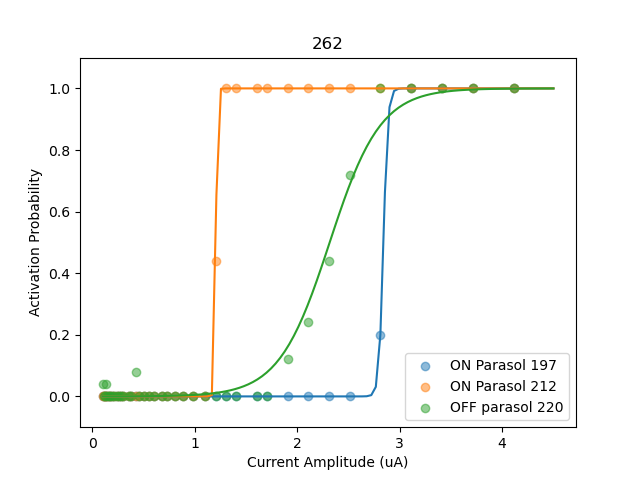

In [59]:
triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
all_cells = np.sort(np.concatenate((targets, nontargets)).astype(int))
all_signals = []

for elec in triplet_elecs:
    filepath_1elec = os.path.join(gsort_path_1elec, dataset, estim_1elec, wnoise, "p" + str(elec))
    plt.figure()
    plt.title(str(elec))
    plt.ylim(-0.1, 1.1)
    plt.ylabel('Activation Probability')
    plt.xlabel('Current Amplitude (uA)')
    
    cell_signals = []
    for cell in all_cells:
        k = 0
        probs = []
        trials = []
        signals = []
        while True:
            try:
                with open(os.path.join(filepath_1elec, "gsort_single_v2_n" + str(cell) + "_p" + str(elec) + "_k" + str(k) + ".pkl"), "rb") as f:
                    prob_dict = pickle.load(f)
                    probs.append(prob_dict["cosine_prob"][0])
                    trials.append(prob_dict["num_trials"])
                    electrode_list = prob_dict["electrode_list"]
                                        
                signal = oldlv.get_oldlabview_pp_data(os.path.join(ANALYSIS_BASE, dataset, estim_1elec), 
                                                      elec, k)[:,electrode_list,:55]
                signals.append(signal)
            except:
                break
            
            k += 1
        
        cell_signals.append(signals)
        trials = np.array(trials, dtype=int)
        probs = np.array(probs)

        if len(probs) > 0:    
            probs = fitting.disambiguate_sigmoid(probs, spont_limit = 0.15, noise_limit = 0.1)

            X_bin, y_bin = fitting.convertToBinaryClassifier(probs, trials, Ivals[:k].reshape(-1, 1))
        
            results = minimize(fitting.negLL, x0=np.array([-1, 1]), args=(X_bin, y_bin, False, 'none'))
        
            currs = np.linspace(0.1, 4.5, 100)
            plt.plot(currs, fitting.fsigmoid(sm.add_constant(currs.reshape(-1, 1)), results.x))
            plt.scatter(Ivals[:k], probs, alpha=0.5, 
                        label=vcd.get_cell_type_for_cell(cell) + ' ' + str(cell))
    
    plt.legend()
    
    all_signals.append(cell_signals)
        

In [7]:
def binaryClustering(X, y, T, nll_thr=0.9, min_points_per_cluster=30, child=''):
    print(child)
    print(len(X))
    X_bin_init, y_bin_init = fitting.convertToBinaryClassifier(y, T, X)
    results_init = minimize(fitting.negLL, x0=np.array([-1, 1, 1, 1]), args=(X_bin_init, y_bin_init, False, 'none'))
    nll_MLE_init = fitting.negLL(results_init.x, X_bin_init, y_bin_init, False, 'none')
    print(nll_MLE_init)

    if len(X) >= min_points_per_cluster and nll_MLE_init < nll_thr and results_init.x[0] < 0:
        return [(X, y, results_init.x)]
    elif len(X) < min_points_per_cluster:
        return [(X, y, [np.nan])]
    else:
        clustering = SpectralClustering(n_clusters=2, 
                                        assign_labels='discretize',
                                        affinity='nearest_neighbors').fit(X)

        cluster0 = np.where(clustering.labels_ == 0)[0]
        cluster1 = np.where(clustering.labels_ == 1)[0]

   
        return binaryClustering(X[cluster0], y[cluster0], T[cluster0], nll_thr=nll_thr, min_points_per_cluster=min_points_per_cluster, child='left') + binaryClustering(X[cluster1], y[cluster1], T[cluster1], nll_thr=nll_thr, min_points_per_cluster=min_points_per_cluster, child='right') 

In [67]:
t_weights = []
t_amps = []
t_probs = []
for t in targets:
    X, y, T = mutils.loadNewLVData(electrical_path, gsort_path, dataset, estim, wnoise, p, t,
                                   downsample=False, downsample_trials=20, downsample_factor=2)
    t_amps.append(X)
    t_probs.append(y)
    output = binaryClustering(X, y, T, nll_thr=0.9, min_points_per_cluster=30)

    cell_weights = []
    for i in range(len(output)):
        print(output[i][2])

        if len(output[i][2]) > 1:
            OLS_X = sm.add_constant(output[i][0], has_constant='add')
            OLS_y = np.log(output[i][1] / (1 - output[i][1]))

            OLS_w = (np.linalg.inv(OLS_X.T @ OLS_X) @ OLS_X.T) @ OLS_y
            print(OLS_w)
            
            cell_weights.append(output[i][2])
            normal = output[i][2][1:]

            d = output[i][2][0]
            xmin = np.amin(output[i][0][:, 0])
            xmax = np.amax(output[i][0][:, 0])
            ymin = np.amin(output[i][0][:, 1])
            ymax = np.amax(output[i][0][:, 1])

            # create x,y
            xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))

            # calculate corresponding z
            z = (-d - normal[0] * xx - normal[1] * yy) / normal[2]
            z[z > 1.8] = np.nan
            z[z < -1.8] = np.nan

            # plot the surface
            fig = plt.figure()
            fig.clear()
            ax = Axes3D(fig)
            ax.plot_surface(xx, yy, z, alpha=0.5)
            plt.xlabel(r'$I_1$')
            plt.ylabel(r'$I_2$')
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$')

            scat = ax.scatter(output[i][0][:, 0], 
                        output[i][0][:, 1],
                        output[i][0][:, 2], marker='o', s=20, c=output[i][1], alpha=0.8)

            clb = plt.colorbar(scat)
            plt.show()
            
    t_weights.append(np.array(cell_weights))

KeyboardInterrupt: 

In [9]:
t_weights

[array([[-11.31950494,   2.38953513,   5.40486963,   4.5855056 ],
        [-17.30836173,   3.3765041 ,   8.85352249,   2.53624822],
        [-16.4403748 ,   1.14525558,   6.6886461 ,  -2.46183762],
        [-12.77800724,  -1.29578162,  -8.03934539,  -0.74606107],
        [-19.51189943,  -2.73019206, -12.22660654,  -3.38933404],
        [-15.45096858,  -1.40353087,  -0.71796909,  -8.12037079],
        [-20.10993807,  -3.15966158,  -9.47682473,  -9.77307746],
        [-18.43129132,  -2.87682748,  -8.53808052,  -8.91423306]]),
 array([[-10.4470522 ,  -5.21126471,  -4.6646631 , -10.10793456],
        [ -8.43868248,  -3.49083696,  -4.35167218,  -3.37117421],
        [-10.99849827,  -5.69046423,  -6.33480812,  -9.02523028],
        [ -7.34915689,   4.14410917,   3.88446938,   6.27020808]])]

In [14]:
import operator as op
import itertools as it

In [24]:
def cartesian_product_pp(arrays, out=None):
    la = len(arrays)
    h, w = zip(*map(op.attrgetter('shape'), arrays))
    w = np.fromiter(it.chain([0], w), int, la+ 1)
    W = w.cumsum()
    h = *h, W[la]
    dtype = np.result_type(*arrays)
    arr = np.empty(h, dtype=dtype)
    arrs = *it.accumulate(it.chain((arr,), it.repeat(0, la-1)), np.ndarray.__getitem__),
    idx = slice(None), *it.repeat(None, la-1)
    for i in range(la-1, 0, -1):
        arrs[i][..., W[i]:W[i+1]] = arrays[i][idx[:la-i]]
        arrs[i-1][1:] = arrs[i]
    arr[..., W[0]:W[1]] = arrays[0][idx]
    return arr.reshape(-1, W[la])

In [29]:
target_combos_flat = cartesian_product_pp(t_weights)

In [36]:
target_combos = np.reshape(target_combos_flat, (len(target_combos_flat), len(targets), 
                                                int(target_combos_flat.shape[-1] / len(targets))))


2138
0.983128481282256
left
1120
0.8608056207681015
right
1018
0.8586333121731999
[-4.33275754 -4.10549872 -2.12563513 -2.06463654]


<IPython.core.display.Javascript object>


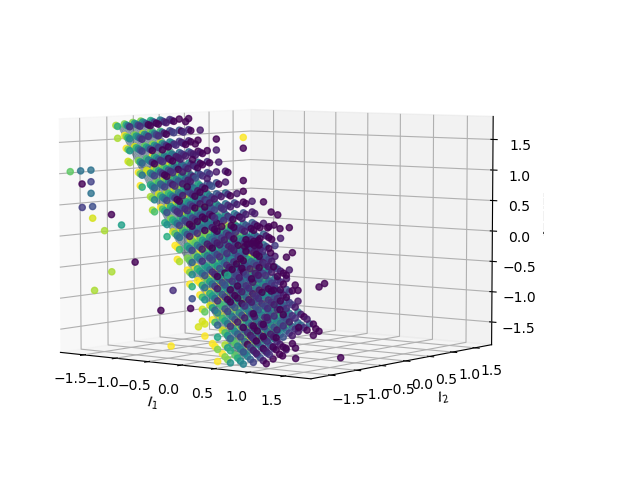

[-4.40328198  3.56806541  1.85111982  1.74991001]


/tmp/ipykernel_8759/394785951.py:35: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


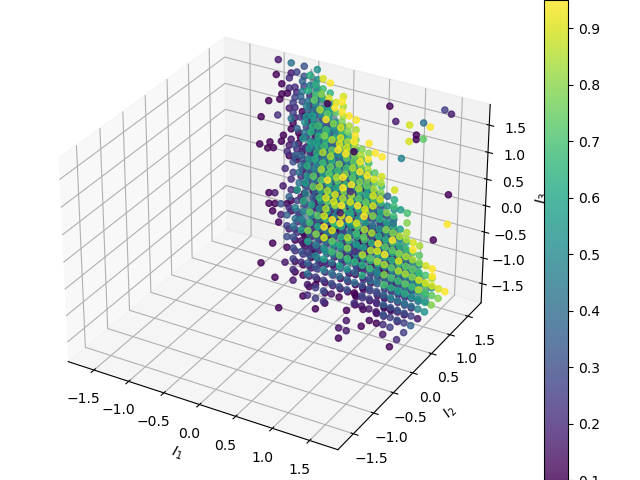

In [40]:
nt_weights = []
nt_amps = []
nt_probs = []
for nt in nontargets:
    X, y, T = mutils.loadNewLVData(electrical_path, gsort_path, dataset, estim, wnoise, p, nt,
                                   downsample=False, downsample_trials=20, downsample_factor=2)
    nt_amps.append(X)
    nt_probs.append(y)
    output = binaryClustering(X, y, T, nll_thr=0.9, min_points_per_cluster=30)

    for i in range(len(output)):
        print(output[i][2])

        if len(output[i][2]) > 1:
            nt_weights.append(output[i][2])
            normal = output[i][2][1:]

            d = output[i][2][0]
            xmin = np.amin(output[i][0][:, 0])
            xmax = np.amax(output[i][0][:, 0])
            ymin = np.amin(output[i][0][:, 1])
            ymax = np.amax(output[i][0][:, 1])

            # create x,y
            xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))

            # calculate corresponding z
            z = (-d - normal[0] * xx - normal[1] * yy) / normal[2]
            z[z > 1.8] = np.nan
            z[z < -1.8] = np.nan

            # plot the surface
            fig = plt.figure()
            fig.clear()
            ax = Axes3D(fig)
            ax.plot_surface(xx, yy, z, alpha=0.5)
            plt.xlabel(r'$I_1$')
            plt.ylabel(r'$I_2$')
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$')

            scat = ax.scatter(output[i][0][:, 0], 
                        output[i][0][:, 1],
                        output[i][0][:, 2], marker='o', s=20, c=output[i][1], alpha=0.8)

            clb = plt.colorbar(scat)
            plt.show()

nt_weights = np.vstack((nt_weights))

In [41]:
target_combos

array([[[-11.31950494,   2.38953513,   5.40486963,   4.5855056 ],
        [-10.4470522 ,  -5.21126471,  -4.6646631 , -10.10793456]],

       [[-11.31950494,   2.38953513,   5.40486963,   4.5855056 ],
        [ -8.43868248,  -3.49083696,  -4.35167218,  -3.37117421]],

       [[-11.31950494,   2.38953513,   5.40486963,   4.5855056 ],
        [-10.99849827,  -5.69046423,  -6.33480812,  -9.02523028]],

       [[-11.31950494,   2.38953513,   5.40486963,   4.5855056 ],
        [ -7.34915689,   4.14410917,   3.88446938,   6.27020808]],

       [[-17.30836173,   3.3765041 ,   8.85352249,   2.53624822],
        [-10.4470522 ,  -5.21126471,  -4.6646631 , -10.10793456]],

       [[-17.30836173,   3.3765041 ,   8.85352249,   2.53624822],
        [ -8.43868248,  -3.49083696,  -4.35167218,  -3.37117421]],

       [[-17.30836173,   3.3765041 ,   8.85352249,   2.53624822],
        [-10.99849827,  -5.69046423,  -6.33480812,  -9.02523028]],

       [[-17.30836173,   3.3765041 ,   8.85352249,   2.5362482

In [42]:
nt_weights

array([[-4.33275754, -4.10549872, -2.12563513, -2.06463654],
       [-4.40328198,  3.56806541,  1.85111982,  1.74991001]])

In [43]:
def compute_pt(T):
    return 1/(np.exp(T)+1)

def compute_pn(T):
    return np.exp(T)/(np.exp(T)+1)

In [52]:
I_max = 1.78125
selec_vals = np.zeros(len(target_combos))
x_vals = np.zeros((len(target_combos), 3))
for i in range(len(target_combos)):
    print(i)
    T_t = cp.Variable(1)
    T_n = cp.Variable(1)
    x = cp.Variable(3)

    constraints = [
        -target_combos[i, :, 0] - target_combos[i, :, 1:] @ x  <= T_t,
        nt_weights[:, 0] + nt_weights[:, 1:] @ x <= T_n,
        x[0] <= 1.4,
        -I_max <= x[0],
        x[1] <= I_max,
        -I_max <= x[1], 
        x[2] <= I_max,
        -I_max <= x[2],  
    ]

    objective_function = cp.exp(T_n) + cp.exp(T_t)

    objective = cp.Minimize(objective_function)
    prob = cp.Problem(objective, constraints)
    opt_val  = prob.solve()
    print(f"Optimal value {opt_val}")

    print(f"optimal p_t {compute_pt(T_t.value)[0]}")
    print(f"optimal p_n {compute_pn(T_n.value)[0]}")
    print(f"optimal T_t {T_t.value[0]}")
    print(f"optimal T_n {T_n.value[0]}")
    print(x.value)

    selec_vals[i] = compute_pt(T_t.value)[0] * (1 - compute_pn(T_n.value)[0])
    x_vals[i] = x.value

0
Optimal value 1093.7437154570084
optimal p_t 0.0009143364365247595
optimal p_n 0.5132376365062913
optimal T_t 6.996397207064628
optimal T_n 0.05296292295088054
[ 1.19839856  1.78125    -1.78124998]
1
Optimal value 2594.350024180864
optimal p_t 0.00038539282426118944
optimal p_n 0.37300712817013904
optimal T_t 7.860861953988454
optimal T_n -0.5193376420389676
[-1.78124999 -0.08380025  1.78124999]
2
Optimal value 3092.915667039345
optimal p_t 0.00032333451201247787
optimal p_n 0.5334594213220241
optimal T_t 8.036499742946297
optimal T_n 0.13403800471639665
[-1.78124998  1.78124999 -0.45536079]
3
Optimal value 0.09086451983152202
optimal p_t 0.9483889772592593
optimal p_n 0.03516332020904453
optimal T_t -2.911029462983221
optimal T_n -3.3119553434880706
[-1.49184704  1.78124996  1.78124995]
4
Optimal value 53.1235740045682
optimal p_t 0.018521675373461815
optimal p_n 0.1172143572392774
optimal T_t 3.970118241490155
optimal T_n -2.0190780392707897
[ 0.61767988  1.78124999 -1.78124999]
5


In [53]:
selec_vals

array([4.45064565e-04, 2.41638554e-04, 1.50848670e-04, 9.15040472e-01,
       1.63506691e-02, 2.70128233e-04, 2.18162958e-03, 4.03204997e-01,
       4.30063076e-01, 1.70630825e-03, 1.64958156e-01, 5.28247978e-02,
       6.91510563e-01, 6.53338972e-01, 6.91510478e-01, 3.30230706e-01,
       9.33573773e-01, 6.53338967e-01, 9.33573776e-01, 2.85732255e-02,
       1.70166287e-01, 1.67212812e-01, 1.70166293e-01, 1.65064430e-03,
       9.69035222e-01, 6.53338969e-01, 9.69035240e-01, 2.69381151e-04,
       9.64755998e-01, 6.53338966e-01, 9.64756005e-01, 3.22682683e-04])

In [54]:
selec_vals[np.argsort(selec_vals)]

array([1.50848670e-04, 2.41638554e-04, 2.69381151e-04, 2.70128233e-04,
       3.22682683e-04, 4.45064565e-04, 1.65064430e-03, 1.70630825e-03,
       2.18162958e-03, 1.63506691e-02, 2.85732255e-02, 5.28247978e-02,
       1.64958156e-01, 1.67212812e-01, 1.70166287e-01, 1.70166293e-01,
       3.30230706e-01, 4.03204997e-01, 4.30063076e-01, 6.53338966e-01,
       6.53338967e-01, 6.53338969e-01, 6.53338972e-01, 6.91510478e-01,
       6.91510563e-01, 9.15040472e-01, 9.33573773e-01, 9.33573776e-01,
       9.64755998e-01, 9.64756005e-01, 9.69035222e-01, 9.69035240e-01])

In [55]:
x_vals[np.argsort(selec_vals)]

array([[-1.78124998,  1.78124999, -0.45536079],
       [-1.78124999, -0.08380025,  1.78124999],
       [ 1.39999999, -1.78124999,  0.05072184],
       [-0.60132117,  1.78125   , -1.78124999],
       [ 1.39999999, -1.78124999,  0.08009654],
       [ 1.19839856,  1.78125   , -1.78124998],
       [ 1.39999999,  1.78124999, -1.6723859 ],
       [-1.65605043,  1.56689787, -1.78124999],
       [-0.01659506,  1.78124999, -1.78124999],
       [ 0.61767988,  1.78124999, -1.78124999],
       [-0.09760234, -1.78124999,  1.78124998],
       [ 0.98816542,  1.78124998, -0.80847509],
       [-0.88726693,  1.78124999, -1.78124999],
       [ 0.14427148, -0.48115164, -1.78124999],
       [-1.02259651,  1.78124957, -1.78125   ],
       [-1.02259652,  1.78124966, -1.78125   ],
       [ 0.60896724, -1.78125   ,  1.78124999],
       [-0.72659676,  1.78125   ,  1.78124999],
       [-0.09598793,  1.78125   , -1.78125   ],
       [ 1.13357119, -1.78125   , -1.78124999],
       [ 1.13357124, -1.78125   , -1.781

In [56]:
selec_vec = x_vals[np.argsort(selec_vals)[-1]]

<IPython.core.display.Javascript object>


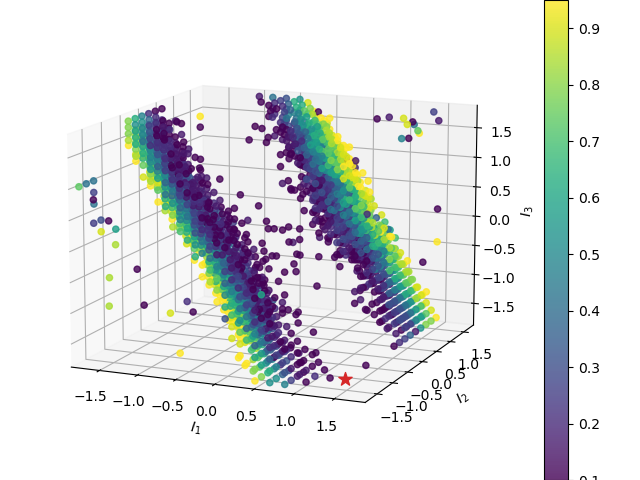

/tmp/ipykernel_8759/750019906.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


In [57]:
for i in range(len(nt_amps)):
    fig = plt.figure()
    fig.clear()
    ax = Axes3D(fig)
    plt.xlabel(r'$I_1$')
    plt.ylabel(r'$I_2$')
    plt.xlim(-1.8, 1.8)
    plt.ylim(-1.8, 1.8)
    ax.set_zlim(-1.8, 1.8)
    ax.set_zlabel(r'$I_3$')

    scat = ax.scatter(nt_amps[i][:, 0], 
                nt_amps[i][:, 1],
                nt_amps[i][:, 2], marker='o', s=20, c=nt_probs[i], alpha=0.8)

    ax.scatter(selec_vec[0], selec_vec[1], selec_vec[2], c='tab:red', marker='*', s=100)

    clb = plt.colorbar(scat)
    plt.show()

<IPython.core.display.Javascript object>


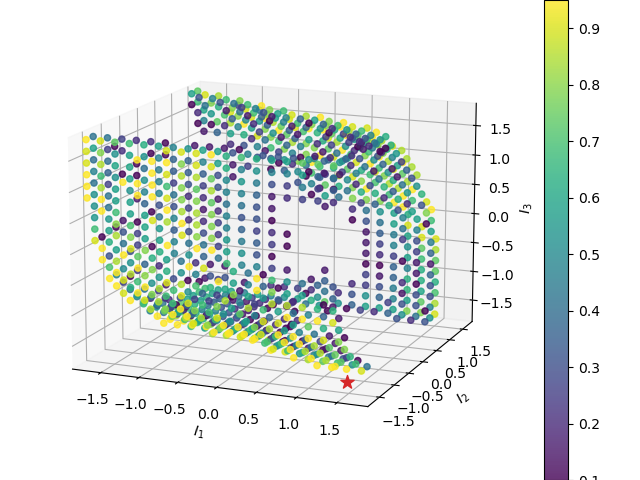

/tmp/ipykernel_8759/4199416486.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


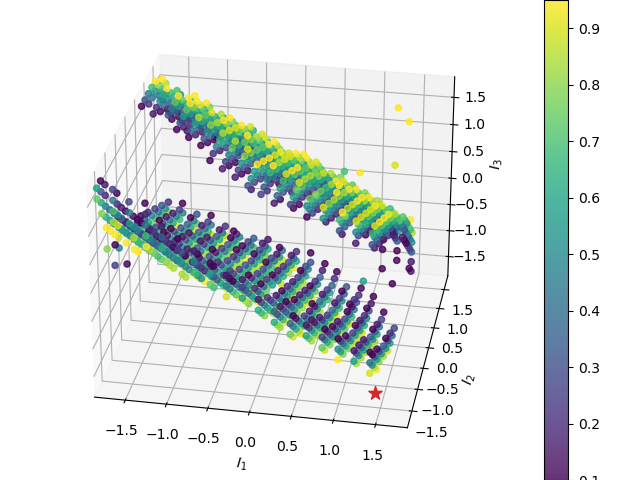

In [58]:
for i in range(len(t_amps)):
    fig = plt.figure()
    fig.clear()
    ax = Axes3D(fig)
    plt.xlabel(r'$I_1$')
    plt.ylabel(r'$I_2$')
    plt.xlim(-1.8, 1.8)
    plt.ylim(-1.8, 1.8)
    ax.set_zlim(-1.8, 1.8)
    ax.set_zlabel(r'$I_3$')

    scat = ax.scatter(t_amps[i][:, 0], 
                t_amps[i][:, 1],
                t_amps[i][:, 2], marker='o', s=20, c=t_probs[i], alpha=0.8)

    ax.scatter(selec_vec[0], selec_vec[1], selec_vec[2], c='tab:red', marker='*', s=100)

    clb = plt.colorbar(scat)
    plt.show()